# Report for Ratings-Results

This report can be used to get an overview on the state of the evaluation.<br/>
It pulls the current ratings from firebase and uses different aggregations in order to create a number of visualizations and statistics.

### Pulling the data

In [1]:
from report import create_report_files
pull_data = True

if pull_data:
    create_report_files(
        "../../keys/gs-on-a-budget-firebase-adminsdk-63ws0-509fffaf5f.json",
        "ratings-v7.xlsx",
        "pairs-v7.xlsx",
    )

### Loading and displaying the raw data

In [2]:
import pandas as pd

pairs = pd.read_excel("./pairs-v7.xlsx")
pairs.columns.values

array(['Unnamed: 0', 'rotation', 'model_2', 'initial_distance', 'fov_y',
       'high_detail', 'n_ratings', 'technique_1', 'model_1',
       'technique_2', 'size', 'dataset_name', 'position', 'dataset',
       'aspect', 'id'], dtype=object)

In [3]:
ratings = pd.read_excel("./ratings-v7.xlsx")
ratings["timestamp"] = ratings["timestamp"].apply(pd.to_datetime)
ratings.columns.values

array(['Unnamed: 0', 'technique_2', 'size', 'rating', 'dataset',
       'user_id', 'pair_id', 'technique_1', 'timestamp', 'id', 'rating_1',
       'rating_2'], dtype=object)

### How many ratings are there per pair?

In [4]:
ratings_count_computed = ratings.groupby("pair_id")["id"].count()
df_ratings_count_computed = pd.DataFrame.from_dict({
    "pair_id": ratings_count_computed.index,
    "count": ratings_count_computed.values
}).sort_values("count", ascending=False)
df_ratings_count_computed

,pair_id,count
59,RZWUvL0VhZOyUcUeGEVN,5
58,RBpxGywp1VWPYDuyRPyU,5
60,STM4xI9X7gXL7C5l0YGV,5
95,d04zeljirrXjC9viZKsB,5
29,Ax0MWlYG4Hq3EEDkWFKK,5
...,...,...
139,ufs3gdRSkQhtUMtsWnlh,1
140,vkzw6nGURAR23rFJzMQ8,1
146,x4yFyy0x8GgtgYalqlpa,1
147,xh9segHQ5UyJB9dih4b0,1


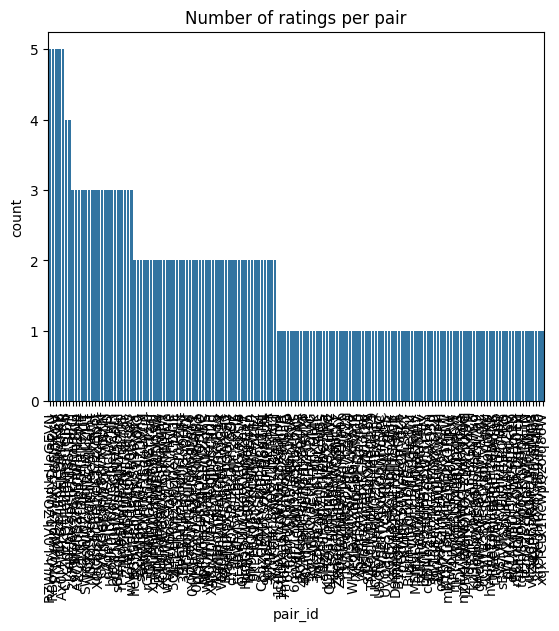

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.barplot(df_ratings_count_computed, x="pair_id", y="count")
plt.xticks(rotation=90)
plt.title("Number of ratings per pair")
plt.show()

In [6]:
# Check what percentage of pairs has been covered once
print(f"{df_ratings_count_computed.shape[0]}/{pairs.shape[0]} pairs have been covered. Thats {round(df_ratings_count_computed.shape[0] / pairs.shape[0] * 100, 2)}%.")

152/189 pairs have been covered. Thats 80.42%.


In [7]:
# sanity check from ratings side if all n_ratings are actually covered by actual ratings
for idx, row in pairs.iterrows():
    if row["n_ratings"] >= 1:
        if id in ratings_count_computed:
            if not (ratings_count_computed[id] == row["n_ratings"]):
                print(f"Error! pair \"{row['id']}\" had different n_ratings than actual rating entities {row['n_ratings']} != {ratings_count_computed[id]}")
        else:
            print(f"Error! pair \"{row['id']}\" had different n_ratings than actual rating entities {row['n_ratings']} != {0}")

Error! pair "0Qbwb7Lis9pOLUVOSIrO" had different n_ratings than actual rating entities 2 != 0
Error! pair "0YwyBZxWsQpHsGv8LS61" had different n_ratings than actual rating entities 2 != 0
Error! pair "0bIsWmiOeRXEyKdMrHB1" had different n_ratings than actual rating entities 2 != 0
Error! pair "0uSshiYpzXHdIn1okZsk" had different n_ratings than actual rating entities 2 != 0
Error! pair "1DMpSYJYgWlOR38X57hm" had different n_ratings than actual rating entities 1 != 0
Error! pair "1SUpmaSAQQNMdD8FibPB" had different n_ratings than actual rating entities 1 != 0
Error! pair "1njZxACnAGt6T5qLMRlL" had different n_ratings than actual rating entities 1 != 0
Error! pair "29sPSf4gbZUmlbkLou5s" had different n_ratings than actual rating entities 1 != 0
Error! pair "2kRptcQx5PSo54pmymCi" had different n_ratings than actual rating entities 3 != 0
Error! pair "2yLwlpCr3EttnrWODivG" had different n_ratings than actual rating entities 1 != 0
Error! pair "3BPbSeLlA1pP4U3oOUfy" had different n_ratings t

In [8]:
# sanity check to see if ratings and n_ratings actually match up
for pair_id, n_ratings in ratings_count_computed.items():
    pair = pairs[pairs["id"] == pair_id]
    if pair.shape[0] != 1:
        print(f'ERROR: pair "{pair_id}" occurs "{pair.shape[0]}" times')
    db_n_ratings = pair["n_ratings"].values[0]
    if n_ratings != db_n_ratings:
        print(
            f'ERROR: pair "{pair_id}" has {n_ratings} but ratings tracker only has {db_n_ratings}'
        )

### How many ratings per user?

In [9]:
ratings_per_user = ratings.groupby("user_id")["id"].count()
df_ratings_per_user = pd.DataFrame.from_dict(
    {"user_id": ratings_per_user.index, "count": ratings_per_user.values}
).sort_values("count", ascending=False)
df_ratings_per_user

,user_id,count
24,d8033277-b91a-4a77-8a57-77b042e1497d,31
22,ba42e8c9-68c7-4fcf-af39-5e18ca1aa5bb,26
3,0a665c40-da19-49db-ad71-f87e7af9c0d8,23
9,4ade5517-3297-49b4-a1e7-a76ae38a8327,19
5,3b6c78e7-b0e6-4c75-a3f3-e1dccc7c9361,14
6,3edd6ae6-6c05-4db2-9b40-f9a22b3e5f8e,12
10,4dc54225-0f2f-40ce-8ed5-1b18cb929d29,12
16,821c56bf-fd47-45ff-b44d-0496db475dc1,8
15,81510f2c-b9e4-4685-bd2e-144d981040a4,6
13,75babeeb-2bc9-41db-b04a-40b4f2c35027,6


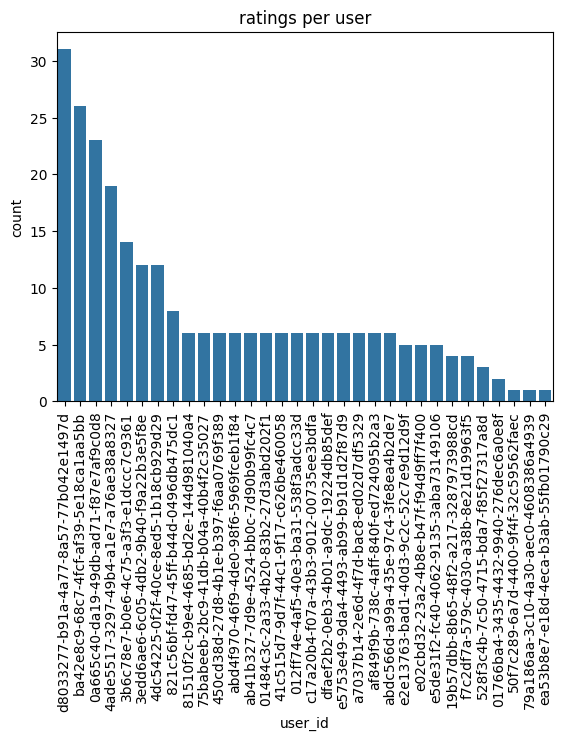

In [10]:
sns.barplot(df_ratings_per_user, x="user_id", y="count")
plt.xticks(rotation=90)
plt.title("ratings per user")
plt.show()

### How many times has every individual model been rated?

In [11]:
rating_records = []

for idx, row in ratings.iterrows():
    pair = pairs[row["pair_id"] == pairs["id"]].iloc[0]
    rating_records.append(
        {
            "model_name": str(pair["model_1"])
            .replace("splats/", "")
            .replace(".ksplat", ""),
            "preferred": row["rating"] == "first",
            "user_id": row["user_id"],
        }
    )
    rating_records.append(
        {
            "model_name": str(pair["model_2"])
            .replace("splats/", "")
            .replace(".ksplat", ""),
            "preferred": row["rating"] == "second",
            "user_id": row["user_id"],
        }
    )

df_ratings_per_model = pd.DataFrame.from_records(rating_records)
df_ratings_per_model

,model_name,preferred,user_id
0,eagles-truck-medium-1,True,d8033277-b91a-4a77-8a57-77b042e1497d
1,geo_gaussian-truck-medium-1,False,d8033277-b91a-4a77-8a57-77b042e1497d
2,default-truck-low-1,True,4dc54225-0f2f-40ce-8ed5-1b18cb929d29
3,eagles-truck-low-1,False,4dc54225-0f2f-40ce-8ed5-1b18cb929d29
4,mini_splatting-stump-medium-1,True,528f3c4b-7c50-4715-bda7-f85f27317a8d
...,...,...,...
515,gaussian_pro-stump-high-1,False,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f
516,mini_splatting-stump-medium-1,True,4ade5517-3297-49b4-a1e7-a76ae38a8327
517,eagles-stump-medium-1,False,4ade5517-3297-49b4-a1e7-a76ae38a8327
518,eagles-room-high-1,False,c17a20b4-f07a-43b3-9012-00735ee3bdfa


In [12]:
count_ratings_per_model = df_ratings_per_model.groupby("model_name")["model_name"].count()
df_count_ratings_per_model = pd.DataFrame.from_dict({
    "model_name": count_ratings_per_model.index,
    "n_ratings": count_ratings_per_model.values,
}).sort_values("n_ratings", ascending=False)
df_count_ratings_per_model

,model_name,n_ratings
0,default-room-high-1,18
14,eagles-stump-medium-1,18
52,mini_splatting-truck-low-1,17
23,gaussian_pro-stump-medium-1,16
27,geo_gaussian-room-high-1,16
...,...,...
40,mcmc-stump-low-1,3
55,mip_splatting-room-low-1,3
24,gaussian_pro-truck-high-1,2
42,mcmc-truck-high-1,2


### Whats the just objectionable difference (JOD) for each dataset/approach/size?

In [13]:
from typing import NamedTuple
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from matplotlib import pyplot as plt


index = {
    "default": 0,
    "mcmc": 1,
    "mini_splatting": 2,
    "eagles": 3,
    "mip_splatting": 4,
    "gaussian_pro": 5,
    "geo_gaussian": 6,
}


def create_preference_matrix_from_df(df: pd.DataFrame) -> np.ndarray:
    preferences = np.zeros((7, 7), dtype=np.uint)

    for _, rating in df.iterrows():
        if rating["rating"] == "first":
            preferences[index[rating["technique_1"]]][index[rating["technique_2"]]] = (
                preferences[index[rating["technique_1"]]][index[rating["technique_2"]]]
                + 1
            )
        if rating["rating"] == "second":
            preferences[index[rating["technique_2"]]][index[rating["technique_1"]]] = (
                preferences[index[rating["technique_2"]]][index[rating["technique_1"]]]
                + 1
            )

    return preferences


# Function to calculate log-likelihood
def thurstone_log_likelihood(mu: np.ndarray, C: np.ndarray) -> float:
    n = len(mu)
    log_likelihood = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                p_ij = norm.cdf((mu[i] - mu[j]) / np.sqrt(2))
                log_likelihood += C[i, j] * np.log(
                    p_ij + 1e-9
                )  # Add a small value to avoid log(0)
    return -log_likelihood


class JodResults(NamedTuple):
    default: float
    mcmc: float
    mini_splatting: float
    eagles: float
    mip_splatting: float
    gaussian_pro: float
    geo_gaussian: float

    def to_array(self) -> np.ndarray:
        return np.array(
            [
                self.default,
                self.mcmc,
                self.mini_splatting,
                self.eagles,
                self.mip_splatting,
                self.gaussian_pro,
                self.geo_gaussian,
            ]
        )


def compute_jod(preferences: np.ndarray) -> JodResults:
    # Initial guess for latent qualities
    n_stimuli = preferences.shape[0]
    mu_init = np.zeros(n_stimuli)

    # Optimize latent scores
    result = minimize(
        thurstone_log_likelihood, mu_init, args=(preferences,), method="BFGS"
    )
    [
        default,
        mcmc,
        mini_splatting,
        eagles,
        mip_splatting,
        gaussian_pro,
        geo_gaussian,
    ] = result.x

    return JodResults(
        default,
        mcmc,
        mini_splatting,
        eagles,
        mip_splatting,
        gaussian_pro,
        geo_gaussian,
    )


def plot_jod_full() -> pd.DataFrame:
    _, axs = plt.subplots(3, 3, sharex=True, sharey=True)

    records = []

    for i, size in enumerate(["low", "medium", "high"]):
        for j, dataset in enumerate(["room", "stump", "truck"]):
            current_ratings = ratings[
                (ratings["size"] == size) & (ratings["dataset"] == dataset)
            ]
            preferences = create_preference_matrix_from_df(current_ratings)
            jod_results = compute_jod(preferences)

            axs[i][j].bar(index.keys(), jod_results.to_array())
            if i == 2:
                axs[i][j].tick_params(labelrotation=90)
                plt.setp(axs[i, j], xlabel=dataset)

            if j == 0:
                plt.setp(axs[i, 0], ylabel=size)

            records.append(
                {
                    "size": size,
                    "dataset": dataset,
                    "default": jod_results.default,
                    "mcmc": jod_results.mcmc,
                    "mini_splatting": jod_results.mini_splatting,
                    "eagles": jod_results.eagles,
                    "mip_splatting": jod_results.mip_splatting,
                    "gaussian_pro": jod_results.gaussian_pro,
                    "geo_gaussian": jod_results.geo_gaussian,
                }
            )

    plt.tight_layout()
    plt.show()

    return pd.DataFrame.from_records(records)

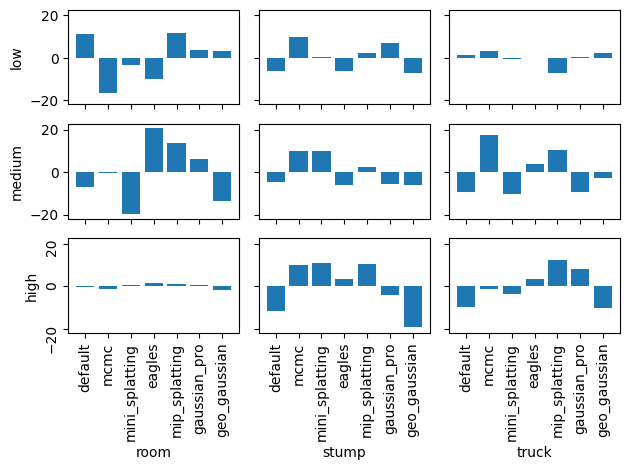

In [14]:
df_jod_full = plot_jod_full()

In [15]:
df_jod_full.to_excel("jod.xlsx")

## Whats the JOD over time as more ratings come in?

In [16]:
def compute_jod_batched(batch_size: int) -> pd.DataFrame:
    records = []

    for i, size in enumerate(["low", "medium", "high"]):
        for j, dataset in enumerate(["room", "stump", "truck"]):
            current_ratings = ratings[
                (ratings["size"] == size) & (ratings["dataset"] == dataset)
            ].sort_values("timestamp", na_position="first")

            batches = [current_ratings[pd.isna(current_ratings["timestamp"])]]

            len_na = pd.isna(current_ratings["timestamp"]).sum()
            len_non_na = pd.notna(current_ratings["timestamp"]).sum()
            for i in range(0, len_non_na, batch_size):
                batches.append(
                    current_ratings.iloc[
                        0:(len_na + min(len_non_na, i + batch_size))
                    ]
                )

            for batch_idx, batch in enumerate(batches):
                preferences = create_preference_matrix_from_df(batch)
                jod_results = compute_jod(preferences)

                records.append(
                    {
                        "size": size,
                        "dataset": dataset,
                        "batch_idx": batch_idx,
                        "default": jod_results.default,
                        "mcmc": jod_results.mcmc,
                        "mini_splatting": jod_results.mini_splatting,
                        "eagles": jod_results.eagles,
                        "mip_splatting": jod_results.mip_splatting,
                        "gaussian_pro": jod_results.gaussian_pro,
                        "geo_gaussian": jod_results.geo_gaussian,
                    }
                )

    return pd.DataFrame.from_records(records)

In [17]:
#df_jod_batched_10 = compute_jod_batched(10)


In [18]:
#df_jod_batched_5 = compute_jod_batched(5)

In [19]:
df_jod_batched_3 = compute_jod_batched(3)

In [20]:
#df_jod_batched_20 = compute_jod_batched(20)

In [21]:
def plot_jod_batched(df_batched: pd.DataFrame) -> None:
    _, axs = plt.subplots(3, 3, sharex=True, sharey=True)
    lines = []
    columns = ["default", "mcmc","mini_splatting",	"eagles", "mip_splatting", "gaussian_pro", "geo_gaussian"]
    for i, size in enumerate(["low", "medium", "high"]):
        for j, dataset in enumerate(["room", "stump", "truck"]):
            current = df_batched[
                (df_batched["size"] == size) & (df_batched["dataset"] == dataset)
            ]
            for col in columns:
                line, = axs[i][j].plot(current["batch_idx"], current[col])
                if i == 0 and j == 0:
                    lines.append(line)
            
            if i == 2:
                axs[i][j].tick_params(labelrotation=90)
                plt.setp(axs[-1, j], xlabel=dataset)
            else:
                pass
                # axs[i][j].set_xticks(["" for _ in range(len(current))])

            if j == 0:
                plt.setp(axs[i, 0], ylabel=size)

    plt.tight_layout()
    axs[1, 2].legend(lines, columns, loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

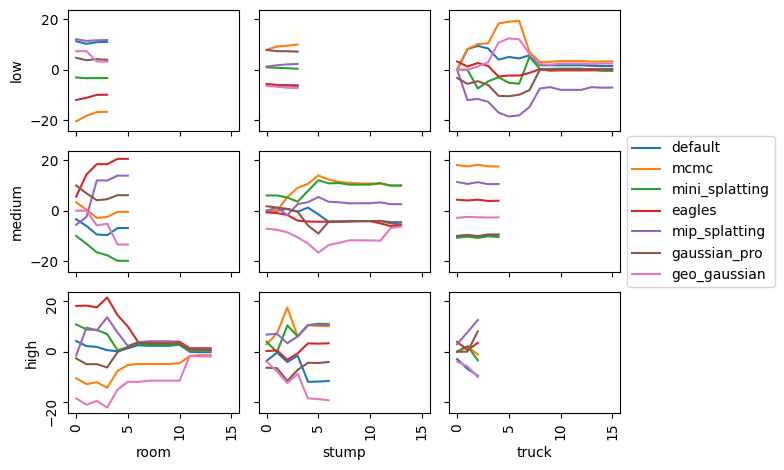

In [22]:
plot_jod_batched(df_jod_batched_3)

## Which dataset+size combination has been rated the least?

In [23]:
df_ratings_count = ratings.groupby(["dataset", "size"])["id"].count().reset_index().sort_values("id")
df_ratings_count

,dataset,size,id
6,truck,high,12
1,room,low,17
2,room,medium,20
4,stump,low,22
3,stump,high,24
8,truck,medium,26
5,stump,medium,44
7,truck,low,46
0,room,high,49


## How stable is the JOD when cross-validating?

In [24]:
from typing import Tuple
import numpy as np
import multiprocessing as mp
from sklearn.model_selection import KFold
import itertools


def cross_validate_jod_for_circumstance(tup: Tuple[int, Tuple[str, str]]) -> np.ndarray:
    k_folds, (size, dataset) = tup
    current = ratings[(ratings["size"] == size) & (ratings["dataset"] == dataset)]
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    jod_estimates = []

    for fold_idx, (train_idx, test_idx) in enumerate(kf.split(current)):
        train_data = current.iloc[train_idx]
        preferences = create_preference_matrix_from_df(train_data)
        jod_results = compute_jod(preferences)
        jod_estimates.append((fold_idx, jod_results))

    return size, dataset, jod_estimates


def compute_k_fold_cross_validation(k_folds: int) -> pd.DataFrame:
    num_workers = min(mp.cpu_count() - 1, 9)
    circumstances = list(
        itertools.product(["low", "medium", "high"], ["room", "stump", "truck"])
    )
    with mp.Pool(num_workers) as pool:
        results = pool.map(
            cross_validate_jod_for_circumstance,
            zip(
                [10 for _ in range(len(circumstances))],
                circumstances,
            ),
        )

    records = []

    for size, dataset, jod_estimates in results:
        for fold_idx, jod_results in jod_estimates:
            records.append(
                {
                    "size": size,
                    "dataset": dataset,
                    "fold_idx": fold_idx,
                    "default": jod_results.default,
                    "mcmc": jod_results.mcmc,
                    "mini_splatting": jod_results.mini_splatting,
                    "eagles": jod_results.eagles,
                    "mip_splatting": jod_results.mip_splatting,
                    "gaussian_pro": jod_results.gaussian_pro,
                    "geo_gaussian": jod_results.geo_gaussian,
                }
            )

    return pd.DataFrame.from_records(records)


result = compute_k_fold_cross_validation(10)

In [25]:
result.groupby(["size", "dataset"]).agg(["std"])

fold_idx   default      mcmc mini_splatting    eagles  \
                    std       std       std            std       std   
size   dataset                                                         
high   room     3.02765  0.943093  0.923811       0.870132  0.661662   
       stump    3.02765  1.969674  1.422215       4.175759  2.154955   
       truck    3.02765  1.446839  1.814174       2.100289  1.464660   
low    room     3.02765  0.891263  2.355430       0.591698  1.673421   
       stump    3.02765  1.979876  1.267076       1.143654  1.437284   
       truck    3.02765  2.106833  3.575804       2.367304  0.783293   
medium room     3.02765  1.974601  3.005371       3.266925  2.614784   
       stump    3.02765  0.914518  0.739996       2.109808  1.428977   
       truck    3.02765  1.343988  2.655241       3.322681  1.361519   

               mip_splatting gaussian_pro geo_gaussian  
                         std          std          std  
size   dataset                                          
high   room         0.913598     0.681125     2.994186  
       stump        1.489879     1.713635     2.259044  
       truck        3.359460     2.527848     1.980695  
low    room         1.157969     0.766370     0.800492  
       stump        0.987440     1.695390     3.368333  
       truck        2.230103     1.061313     1.894294  
medium room         4.702986     1.954276     3.077433  
       stump        0.910163     1.085911     1.186515  
       truck        2.306228     2.347281     0.793064

<Axes: xlabel='None-None', ylabel='size-dataset'>

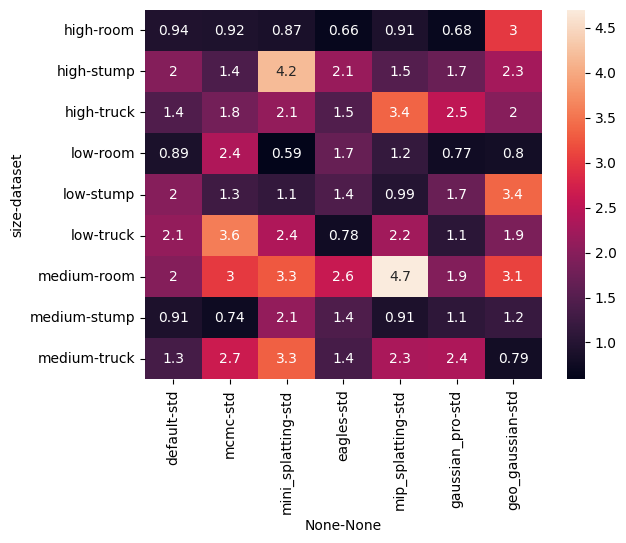

In [26]:
sns.heatmap(
    result.groupby(["size", "dataset"])
    .agg(["std"])[
        [
            "default",
            "mcmc",
            "mini_splatting",
            "eagles",
            "mip_splatting",
            "gaussian_pro",
            "geo_gaussian",
        ]
    ]
    .apply(lambda x: round(x, 2)),
    annot=True,
)

## How stable is the ranking according to the JOD across all the different circustances and models?

In [27]:
# overall rank stability
ranks = result[
    [
        "default",
        "mcmc",
        "mini_splatting",
        "eagles",
        "mip_splatting",
        "gaussian_pro",
        "geo_gaussian",
    ]
].rank(axis=1, ascending=False)

rank_counts = ranks.apply(pd.Series.value_counts, axis=0).fillna(0)
df_rank_overall = (rank_counts / ranks.shape[0] * 100).apply(round)

<Axes: >

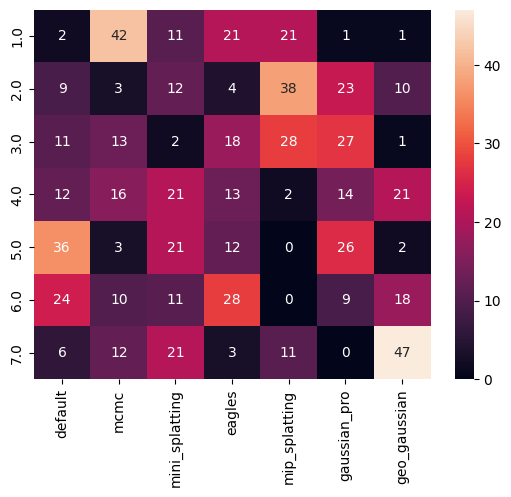

In [28]:
import seaborn as sns

sns.heatmap(df_rank_overall, annot=True)

In [29]:
def compute_rank_consistency(df_jod_cv: pd.DataFrame) -> pd.DataFrame:
    records = []

    for size in ["low", "medium", "high"]:
        for dataset in ["room", "stump", "truck"]:
            current = df_jod_cv[
                (df_jod_cv["size"] == size) & (df_jod_cv["dataset"] == dataset)
            ]
            ranks = current[
                [
                    "default",
                    "mcmc",
                    "mini_splatting",
                    "eagles",
                    "mip_splatting",
                    "gaussian_pro",
                    "geo_gaussian",
                ]
            ].rank(axis=1, ascending=False)
            rank_counts = ranks.apply(pd.Series.value_counts, axis=0).fillna(0)
            best_rank = (rank_counts.max(axis=0) / ranks.shape[0] * 100).apply(round)
            (
                default,
                mcmc,
                mini_splatting,
                eagles,
                mip_splatting,
                gaussian_pro,
                geo_gaussian,
            ) = best_rank.values
            records.append(
                {
                    "size": size,
                    "dataset": dataset,
                    "default": default,
                    "mcmc": mcmc,
                    "mini_splatting": mini_splatting,
                    "eagles": eagles,
                    "mip_splatting": mip_splatting,
                    "gaussian_pro": gaussian_pro,
                    "geo_gaussian": geo_gaussian,
                }
            )
    return pd.DataFrame.from_records(records)

# Rank consistency per circumstance
rank_consistency = compute_rank_consistency(result).set_index(["size", "dataset"])
rank_consistency

default  mcmc  mini_splatting  eagles  mip_splatting  \
size   dataset                                                         
low    room          80    90             100      90             80   
       stump         70   100             100      70            100   
       truck        100    90              80      60            100   
medium room          80    70              90     100             90   
       stump        100    80              80      70            100   
       truck         70   100             100      90             90   
high   room         100    80              80      90             60   
       stump        100    90              80      90             80   
       truck         50    70              70      70             90   

                gaussian_pro  geo_gaussian  
size   dataset                              
low    room               90            90  
       stump             100           100  
       truck              80            90  
medium room               80            80  
       stump              90            80  
       truck              70           100  
high   room               70            80  
       stump              90           100  
       truck              80            50

In [30]:
df_ratings_per_model["model"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[0]
)
df_ratings_per_model["dataset"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[1]
)
df_ratings_per_model["size"] = df_ratings_per_model["model_name"].apply(
    lambda name: name.split("-")[2]
)
df_ratings_per_model
# df_grouped["n_splats"] = df_grouped["size"].apply(
#     lambda size: {
#         "low": 117856,
#         "medium": 412235,
#         "high": 1093135,
#         "extended": 2186270,
#     }[size]
# )
# df_grouped

,model_name,preferred,user_id,model,dataset,size
0,eagles-truck-medium-1,True,d8033277-b91a-4a77-8a57-77b042e1497d,eagles,truck,medium
1,geo_gaussian-truck-medium-1,False,d8033277-b91a-4a77-8a57-77b042e1497d,geo_gaussian,truck,medium
2,default-truck-low-1,True,4dc54225-0f2f-40ce-8ed5-1b18cb929d29,default,truck,low
3,eagles-truck-low-1,False,4dc54225-0f2f-40ce-8ed5-1b18cb929d29,eagles,truck,low
4,mini_splatting-stump-medium-1,True,528f3c4b-7c50-4715-bda7-f85f27317a8d,mini_splatting,stump,medium
...,...,...,...,...,...,...
515,gaussian_pro-stump-high-1,False,e2e13763-bad1-40d3-9c2c-52c7e9d12d9f,gaussian_pro,stump,high
516,mini_splatting-stump-medium-1,True,4ade5517-3297-49b4-a1e7-a76ae38a8327,mini_splatting,stump,medium
517,eagles-stump-medium-1,False,4ade5517-3297-49b4-a1e7-a76ae38a8327,eagles,stump,medium
518,eagles-room-high-1,False,c17a20b4-f07a-43b3-9012-00735ee3bdfa,eagles,room,high


<Axes: ylabel='size-dataset'>

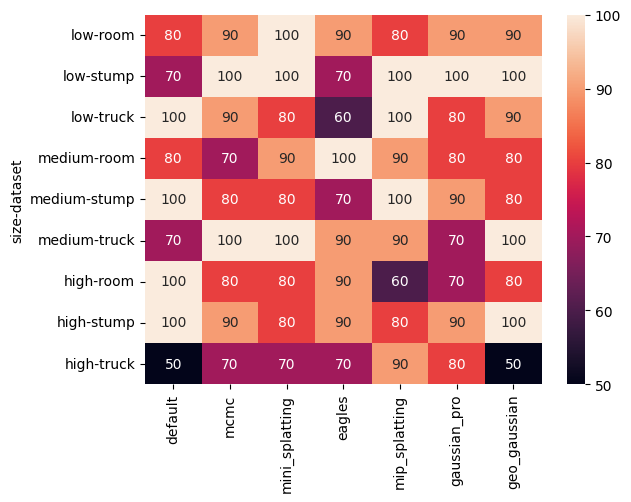

In [31]:
sns.heatmap(rank_consistency, annot=True, fmt = ".3g")

NameError: name 'df_grouped' is not defined

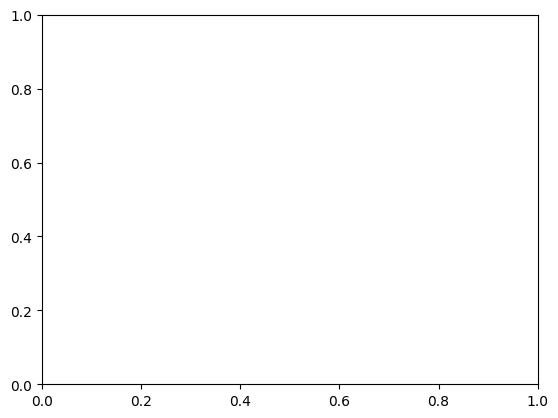

In [32]:
ax = plt.subplot()
sns.lineplot(df_grouped, x="n_splats", y="rating", hue="model", ax=ax)
plt.title("MOS per splat budget (Truck dataset)")
ax.set_xticks([117856, 412235, 1093135, 2186270], ["low", "medium", "high", "extended"])
plt.show()

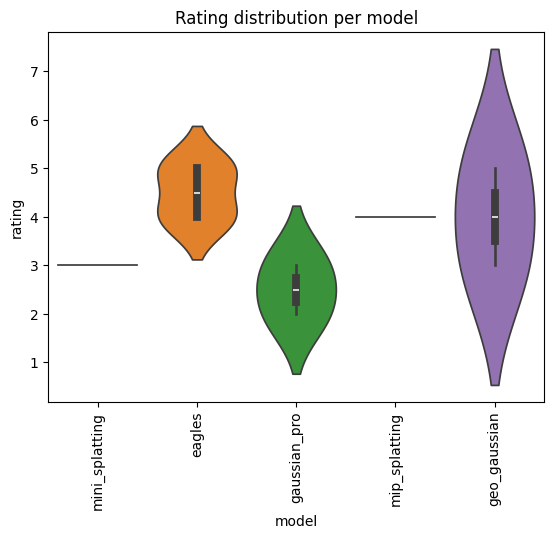

In [96]:
sns.violinplot(df_ratings_truck, x="model", y="rating", hue="model")
plt.title("Rating distribution per model")
plt.xticks(rotation=90)
plt.show()